## Import Libraries

In [1]:
# data preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
import itertools
import collections
from wordcloud import WordCloud
import re

# ml model 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# neural networks
import tensorflow as tf
from keras.preprocessing.text import one_hot, Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, SpatialDropout1D, LSTM

2023-06-25 00:18:27.871574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load Dataset

In [3]:
reviews = pd.read_csv("uw_course_reviews.csv")

In [4]:
reviews.head()

,course_code,course_title,num_ratings,useful,easy,liked,num_reviews,reviews,course_rating,course_rating_int
0,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,go to office hours and practice,liked course,1.0
1,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,One of my least favourite courses. Although th...,disliked course,0.0
2,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,It starts with a very low pace but after midte...,disliked course,0.0
3,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,Took this in 2018 with no programming experien...,liked course,1.0
4,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,I loved everything about cs 115. Great instruc...,liked course,1.0


In [5]:
reviews.isnull().sum()

course_code            0
course_title           0
num_ratings            0
useful                 2
easy                   3
liked                  3
num_reviews            0
reviews                9
course_rating        222
course_rating_int    222
dtype: int64

## Data Preprocessing & EDA of dataset

In [6]:
reviews.duplicated().sum()

6

In [7]:
reviews = reviews.drop_duplicates()
reviews = reviews.dropna(subset=['course_rating'])

In [8]:
reviews['sentiment'] = reviews['course_rating_int'].apply(lambda x:"positive" if x == 1.0 else "negative")
reviews.drop(['course_title', 'num_ratings', 'useful', 'easy', 'liked', 'num_reviews', 'course_rating', 'course_rating_int'],
            axis=1, inplace=True)

In [9]:
#nltk.download('stopwords')
stopwords = stopwords.words('english')

reviews['reviews'] = reviews['reviews'].str.lower()
reviews['reviews'] = reviews['reviews'].str.replace('[^A-Za-z]+',' ',regex=True)
reviews['reviews'] = reviews['reviews'].apply(lambda words:" ".join(word.lower() for word in str(words).split() if word not in stopwords))
reviews['reviews'] = reviews['reviews'].apply(lambda words:re.sub(r'\s+[a-zA-Z]\s+', ' ', words))
reviews['reviews'] = reviews['reviews'].apply(lambda words:re.sub(r'\s+', ' ', words))

In [10]:
reviews.head()

,course_code,reviews,sentiment
0,CS 115,go office hours practice,positive
1,CS 115,one least favourite courses although things ni...,negative
2,CS 115,starts low pace midterm gets really fast canno...,negative
3,CS 115,took programming experience ever started prett...,positive
4,CS 115,loved everything cs great instructors fair ass...,positive


In [11]:
#nltk.download('wordnet')
#nltk.download('punkt')
tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
reviews['tokens'] = reviews['reviews'].apply(lambda text:[lemmatizer.lemmatize(x) for x in tokenizer.tokenize(text)])

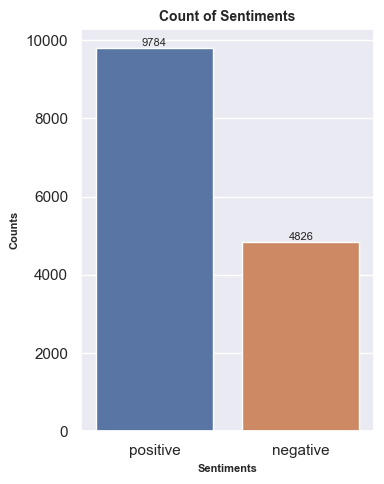

In [12]:
sns.set(style='darkgrid')
fig,ax = plt.subplots(figsize=(4,5),dpi=100)
sns.countplot(data=reviews, x='sentiment')
ax.bar_label(ax.containers[0],fontsize=8)
ax.set_xlabel(r"Sentiments",fontsize=8,fontweight='bold')
ax.set_ylabel(r"Counts",fontsize=8,fontweight='bold')
plt.title('Count of Sentiments',fontweight='bold',fontsize=10,loc='center')
plt.tight_layout()

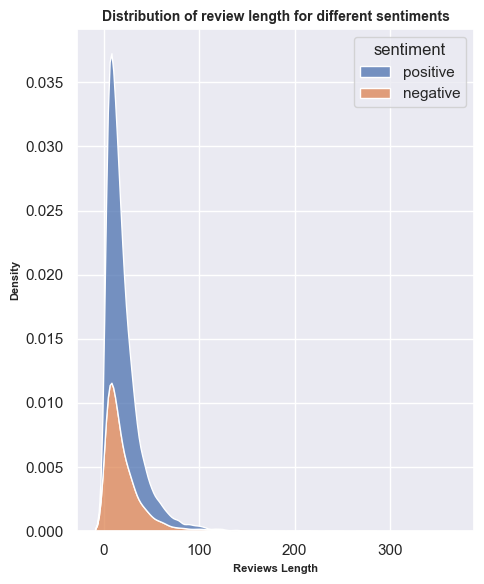

In [13]:
reviews['length'] = reviews['reviews'].str.split().str.len()
fig,ax = plt.subplots(figsize=(5,6),dpi=100)
sns.kdeplot(data=reviews, x='length',hue='sentiment',multiple='stack')
ax.set_xlabel(r"Reviews Length",fontsize=8,fontweight='bold')
ax.set_ylabel(r"Density",fontsize=8,fontweight='bold')
plt.title('Distribution of review length for different sentiments',fontweight='bold',fontsize=10,loc='center')
plt.tight_layout()

/var/folders/jq/3zk57sh96rj5fmr5m8znw03r0000gn/T/ipykernel_69805/54648872.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=words_counter,y='word',x='count',ci=None,orient='h',color='blue')


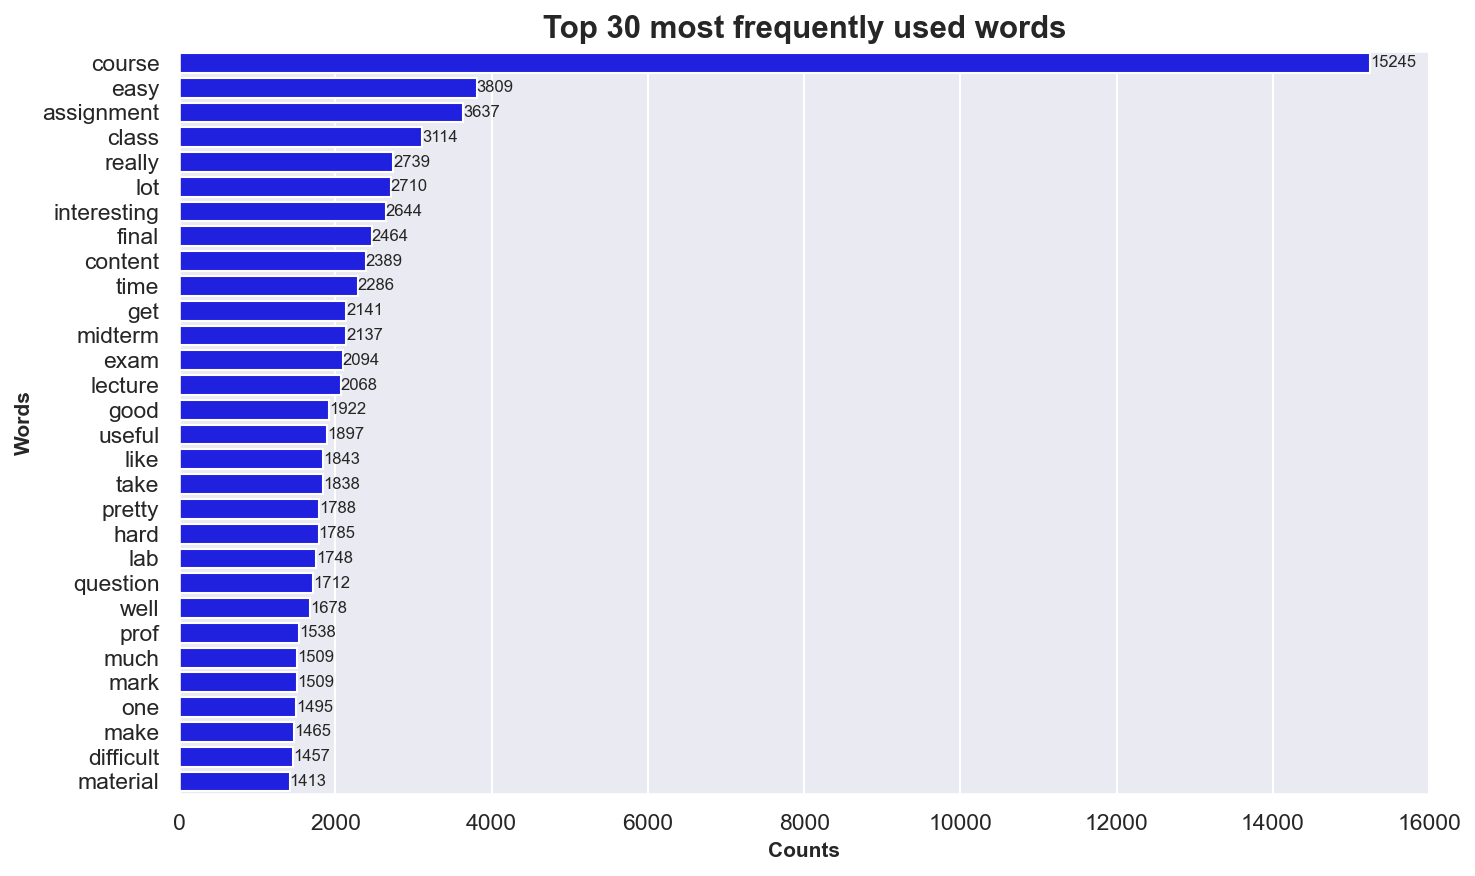

In [14]:
tokens = list(reviews['tokens'])
tokens_list = list(itertools.chain(*tokens))
counts = collections.Counter(tokens_list)
words_counter = pd.DataFrame(counts.most_common(30), columns=['word', 'count'])

fig,ax = plt.subplots(figsize=(10,6),dpi=150)
sns.barplot(data=words_counter,y='word',x='count',ci=None,orient='h',color='blue')
ax.bar_label(ax.containers[0],fontsize=8)
ax.set_xlabel(r"Counts",fontsize=10,fontweight='bold')
ax.set_ylabel(r"Words",fontsize=10,fontweight='bold')
plt.title('Top 30 most frequently used words',fontweight='bold',fontsize=15,loc='center')
plt.tight_layout()

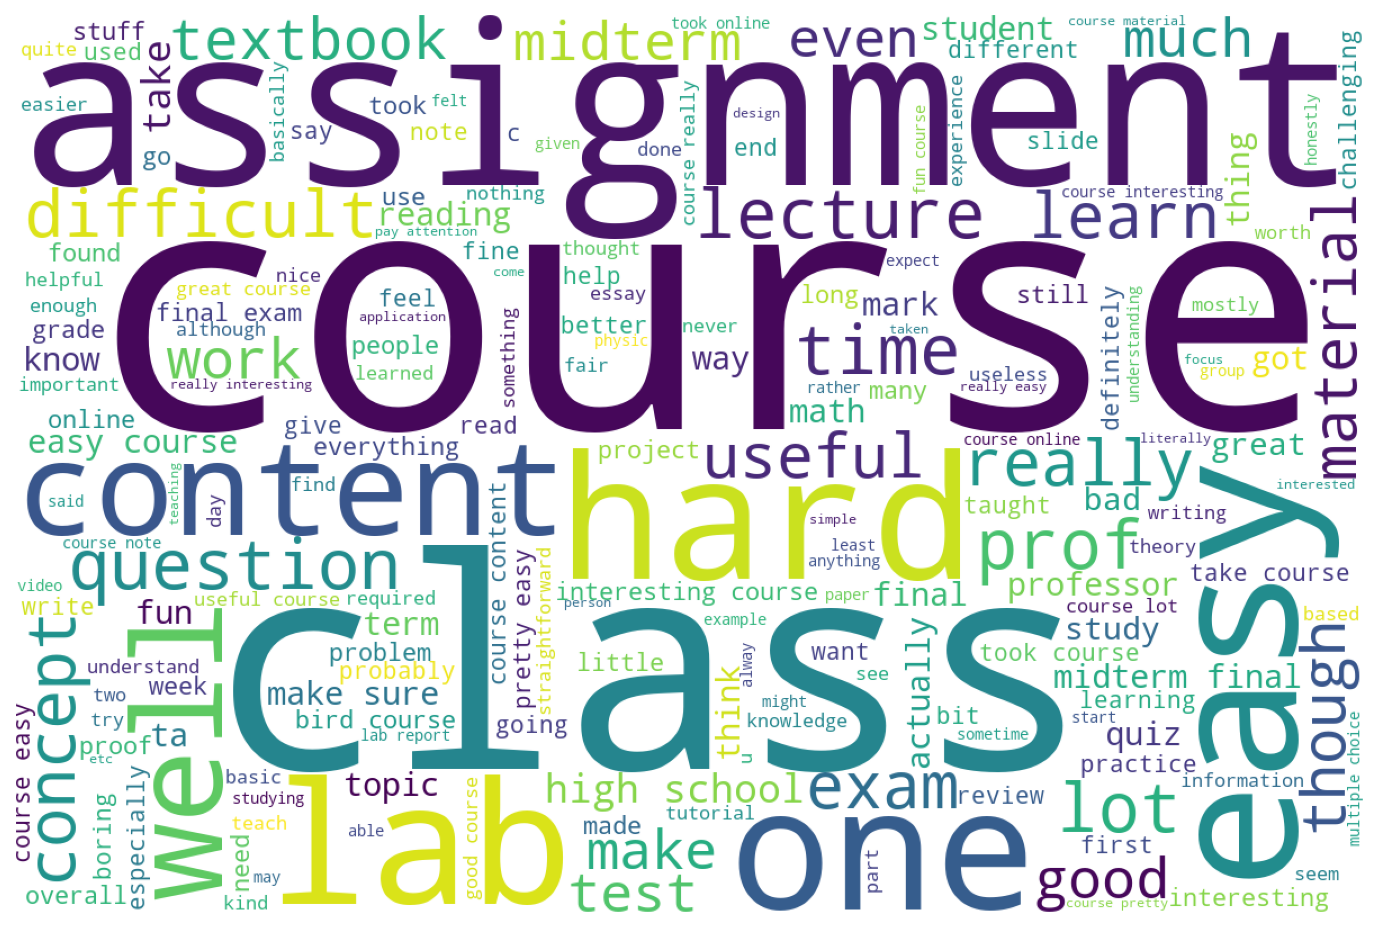

In [15]:
fig,ax = plt.subplots(figsize=(10,6),dpi=150,facecolor=None)
wordcloud = WordCloud(width=1200, height=800, background_color='white').generate(" ".join(tokens_list))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

## Model training using Logistic Regression, SVM & Naive Bayes

In [16]:
reviews['corpus'] = reviews['tokens'].apply(lambda words:" ".join(words))
reviews['label'] = reviews['sentiment'].map({'positive':1, 'negative':0})
X = reviews['corpus']
y = reviews['label']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=101,test_size=0.3)
tf_idf = TfidfVectorizer()
X_train_tfidf = tf_idf.fit_transform(X_train)
X_test_tfidf = tf_idf.transform(X_test)
models = {"Logistic Regression":LogisticRegression(), "Support Vector Machine":SVC(), 
          "Naive Bayes":MultinomialNB()}
for model in models:
    models[model].fit(X_train_tfidf, y_train)
    test_pred = models[model].predict(X_test_tfidf)
    print(model,"\n",classification_report(y_test,test_pred))

Logistic Regression 
               precision    recall  f1-score   support

           0       0.75      0.49      0.59      1474
           1       0.78      0.92      0.84      2909

    accuracy                           0.77      4383
   macro avg       0.76      0.70      0.72      4383
weighted avg       0.77      0.77      0.76      4383

Support Vector Machine 
               precision    recall  f1-score   support

           0       0.79      0.47      0.59      1474
           1       0.78      0.94      0.85      2909

    accuracy                           0.78      4383
   macro avg       0.78      0.70      0.72      4383
weighted avg       0.78      0.78      0.76      4383

Naive Bayes 
               precision    recall  f1-score   support

           0       0.88      0.18      0.29      1474
           1       0.70      0.99      0.82      2909

    accuracy                           0.72      4383
   macro avg       0.79      0.58      0.56      4383
weighted avg 

In [17]:
under = RandomUnderSampler(random_state=42, replacement=True)
X_train_rus, y_train_rus = under.fit_resample(X_train_tfidf,y_train)
models = {"Logistic Regression":LogisticRegression(), "Support Vector Machine":SVC(), 
          "Naive Bayes":MultinomialNB()}
for model in models:
    models[model].fit(X_train_rus, y_train_rus)
    test_pred = models[model].predict(X_test_tfidf)
    print(model,"\n",classification_report(y_test,test_pred))

Logistic Regression 
               precision    recall  f1-score   support

           0       0.55      0.75      0.64      1474
           1       0.84      0.69      0.76      2909

    accuracy                           0.71      4383
   macro avg       0.70      0.72      0.70      4383
weighted avg       0.75      0.71      0.72      4383

Support Vector Machine 
               precision    recall  f1-score   support

           0       0.53      0.77      0.62      1474
           1       0.85      0.65      0.73      2909

    accuracy                           0.69      4383
   macro avg       0.69      0.71      0.68      4383
weighted avg       0.74      0.69      0.70      4383

Naive Bayes 
               precision    recall  f1-score   support

           0       0.59      0.71      0.64      1474
           1       0.84      0.75      0.79      2909

    accuracy                           0.74      4383
   macro avg       0.71      0.73      0.72      4383
weighted avg 

In [18]:
sm = SMOTE(random_state=101)
X_train_sm, y_train_sm = sm.fit_resample(X_train_tfidf,y_train)
models = {"Logistic Regression":LogisticRegression(), "Support Vector Machine":SVC(), 
          "Naive Bayes":MultinomialNB()}
for model in models:
    models[model].fit(X_train_sm, y_train_sm)
    test_pred = models[model].predict(X_test_tfidf)
    print(model,"\n",classification_report(y_test,test_pred))

Logistic Regression 
               precision    recall  f1-score   support

           0       0.59      0.66      0.62      1474
           1       0.82      0.77      0.79      2909

    accuracy                           0.73      4383
   macro avg       0.70      0.71      0.71      4383
weighted avg       0.74      0.73      0.73      4383

Support Vector Machine 
               precision    recall  f1-score   support

           0       0.77      0.48      0.59      1474
           1       0.78      0.93      0.85      2909

    accuracy                           0.78      4383
   macro avg       0.77      0.70      0.72      4383
weighted avg       0.77      0.78      0.76      4383

Naive Bayes 
               precision    recall  f1-score   support

           0       0.68      0.58      0.63      1474
           1       0.80      0.86      0.83      2909

    accuracy                           0.77      4383
   macro avg       0.74      0.72      0.73      4383
weighted avg 

In [19]:
st = SMOTETomek(random_state=777)
X_train_st, y_train_st = st.fit_resample(X_train_tfidf,y_train)
models = {"Logistic Regression":LogisticRegression(), "Support Vector Machine":SVC(), 
          "Naive Bayes":MultinomialNB()}
for model in models:
    models[model].fit(X_train_st, y_train_st)
    test_pred = models[model].predict(X_test_tfidf)
    print(model,"\n",classification_report(y_test,test_pred))

Logistic Regression 
               precision    recall  f1-score   support

           0       0.59      0.66      0.63      1474
           1       0.82      0.77      0.79      2909

    accuracy                           0.73      4383
   macro avg       0.71      0.72      0.71      4383
weighted avg       0.74      0.73      0.74      4383

Support Vector Machine 
               precision    recall  f1-score   support

           0       0.77      0.48      0.59      1474
           1       0.78      0.93      0.85      2909

    accuracy                           0.78      4383
   macro avg       0.78      0.70      0.72      4383
weighted avg       0.78      0.78      0.76      4383

Naive Bayes 
               precision    recall  f1-score   support

           0       0.67      0.58      0.62      1474
           1       0.80      0.85      0.83      2909

    accuracy                           0.76      4383
   macro avg       0.74      0.72      0.73      4383
weighted avg 

## Neural Network 

### Embedding layer using GloVe

In [20]:
X = reviews['reviews']
y = reviews['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# kera tokenizer assign a token (integer) to each word work
# lower integer means more frequent word
# oov_token = True to assign a token to words in test set not present in training set
word_tokenizer = Tokenizer(oov_token=True)
word_tokenizer.fit_on_texts(X_train)
X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [21]:
# add 1 to store dimensions for words which have no pretrained word embeddings
# number of unique tokens
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

11393

In [22]:
# Padding all reviews to fixed length 300
# adding zeros to the edges of the input matrix

maxlen = 300

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [23]:
embeddings_dict = dict()

with open('glove.42B.300d.txt', encoding="utf8") as glove_file:
    contents = glove_file.readlines()
    for line in contents:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dict[word] = vector_dimensions

In [24]:
embedding_matrix = np.zeros((vocab_length, 300))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [25]:
embedding_matrix.shape

(11393, 300)

### Model Training using Simple Neural Network

In [26]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

2023-06-25 00:31:57.458425: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
# Compiling model

snn_model.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['accuracy',
                          tf.keras.metrics.Precision(),
                          tf.keras.metrics.Recall()])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          3417900   
                                                                 
 flatten (Flatten)           (None, 90000)             0         
                                                                 
 dense (Dense)               (None, 1)                 90001     
                                                                 
Total params: 3,507,901
Trainable params: 90,001
Non-trainable params: 3,417,900
_________________________________________________________________
None


In [28]:
# Training the model

snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
74/74 [==============================] - 5s 16ms/step - loss: 0.5804 - accuracy: 0.6984 - precision: 0.7005 - recall: 0.9601 - val_loss: 0.5352 - val_accuracy: 0.7327 - val_precision: 0.7428 - val_recall: 0.9196
Epoch 2/6
74/74 [==============================] - 1s 17ms/step - loss: 0.4561 - accuracy: 0.7943 - precision: 0.7858 - recall: 0.9526 - val_loss: 0.5180 - val_accuracy: 0.7429 - val_precision: 0.7636 - val_recall: 0.8928
Epoch 3/6
74/74 [==============================] - 1s 9ms/step - loss: 0.4142 - accuracy: 0.8202 - precision: 0.8170 - recall: 0.9427 - val_loss: 0.5172 - val_accuracy: 0.7472 - val_precision: 0.7523 - val_recall: 0.9285
Epoch 4/6
74/74 [==============================] - 1s 9ms/step - loss: 0.3839 - accuracy: 0.8368 - precision: 0.8319 - recall: 0.9478 - val_loss: 0.5144 - val_accuracy: 0.7528 - val_precision: 0.7692 - val_recall: 0.9017
Epoch 5/6
74/74 [==============================] - 1s 10ms/step - loss: 0.3629 - accuracy: 0.8475 - precision: 0.8

In [29]:
# Prediction & Evaluation of snn model

snn_score = snn_model.evaluate(X_test, y_test, verbose=1)

92/92 [==============================] - 0s 2ms/step - loss: 0.5392 - accuracy: 0.7464 - precision: 0.7667 - recall: 0.8926


In [30]:
def evaluate_model(prediction):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    prediction = prediction.flatten()
    y_test_array = y_test.to_numpy()
    for i in range(len(prediction)):
        if prediction[i] <= 0.5 and y_test_array[i] == 0:
            true_neg += 1
        elif prediction[i] > 0.5 and y_test_array[i] == 0:
            false_pos += 1
        elif prediction[i] <= 0.5 and y_test_array[i] == 1:
            false_neg += 1
        else:
            true_pos += 1

    print("Performance for negative sentiments:")
    # out of all the negative predicted, how many are true?
    neg_precision = true_neg/(true_neg + false_neg)
    # out of all the negative, how many of being predicted correctly?
    neg_recall = true_neg/(true_neg + false_pos) 
    print("precision: " + str(neg_precision))
    print("recall: " + str(neg_recall) + "\n")

    print("Performance for positive sentiments:")
    # out of all the positive predicted, how many are true?
    pos_precision = true_pos/(true_pos + false_pos)
    # out of all the positive, how many of being predicted correctly?
    pos_recall = true_pos/(true_pos + false_neg) 
    print("precision: " + str(pos_precision))
    print("recall: " + str(pos_recall))
    
    
test_pred = snn_model.predict(X_test)
evaluate_model(test_pred)


92/92 [==============================] - 0s 1ms/step
Performance for negative sentiments:
precision: 0.6749226006191951
recall: 0.45087900723888313

Performance for positive sentiments:
precision: 0.7666959578207382
recall: 0.8925831202046036


In [31]:
X_train_rus, y_train_rus = under.fit_resample(X_train, y_train)
snn_model.fit(X_train_rus, y_train_rus, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
49/49 [==============================] - 0s 9ms/step - loss: 0.4023 - accuracy: 0.8134 - precision: 0.7561 - recall: 0.7417 - val_loss: 0.4491 - val_accuracy: 0.7759 - val_precision: 1.0000 - val_recall: 0.7759
Epoch 2/6
49/49 [==============================] - 0s 9ms/step - loss: 0.3460 - accuracy: 0.8546 - precision: 0.8319 - recall: 0.7672 - val_loss: 0.5401 - val_accuracy: 0.7040 - val_precision: 1.0000 - val_recall: 0.7040
Epoch 3/6
49/49 [==============================] - 1s 11ms/step - loss: 0.3232 - accuracy: 0.8682 - precision: 0.8552 - recall: 0.7806 - val_loss: 0.5453 - val_accuracy: 0.7073 - val_precision: 1.0000 - val_recall: 0.7073
Epoch 4/6
49/49 [==============================] - 0s 10ms/step - loss: 0.3068 - accuracy: 0.8803 - precision: 0.8675 - recall: 0.8035 - val_loss: 0.5739 - val_accuracy: 0.6852 - val_precision: 1.0000 - val_recall: 0.6852
Epoch 5/6
49/49 [==============================] - 0s 10ms/step - loss: 0.2944 - accuracy: 0.8878 - precision: 0.8

## Saving the Logistic Model

In [34]:
reviews['corpus'] = reviews['tokens'].apply(lambda words:" ".join(words))
reviews['label'] = reviews['sentiment'].map({'positive':1, 'negative':0})
X = reviews['corpus']
y = reviews['label']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=101,test_size=0.3)
tf_idf = TfidfVectorizer()
X_train_tfidf = tf_idf.fit_transform(X_train)
X_test_tfidf = tf_idf.transform(X_test)
under = RandomUnderSampler(random_state=42, replacement=True)
X_train_rus, y_train_rus = under.fit_resample(X_train_tfidf,y_train)
final_model = LogisticRegression()
final_model.fit(X_train_rus, y_train_rus)

LogisticRegression()

In [35]:
test_pred = final_model.predict(X_test_tfidf)
print(model,"\n",classification_report(y_test,test_pred))

Naive Bayes 
               precision    recall  f1-score   support

           0       0.55      0.75      0.64      1474
           1       0.84      0.69      0.76      2909

    accuracy                           0.71      4383
   macro avg       0.70      0.72      0.70      4383
weighted avg       0.75      0.71      0.72      4383



In [36]:
import pickle

with open('sentiment_analysis_pkl', 'wb') as file:
    pickle.dump(final_model, file)

In [65]:
with open('tfidf_pkl', 'wb') as file:
    pickle.dump(tf_idf, file)